**Brian Blaylock**  
**January 23, 2019**  

# HRRR Mean Model Spread

> The point is to show that the predictability of the HRRR model varries by time of year, hour, and region.

When is the HRRR model spread greatest?
- Time of day
    - 21-3
    - 3-9
    - 0-15
    - 15-21
- Season
    - DJF
    - MAM
    - JJA
    - SON
- Geophysical location

In [1]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import os
import multiprocessing

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, pluck_hrrr_point, get_hrrr_variable
from BB_HRRR.HRRR_Spread import spread, get_HRRR_value, mean_spread_MP
from BB_maps.my_basemap import draw_centermap, draw_HRRR_map

In [2]:
m = draw_HRRR_map()

In [3]:
LAND = get_hrrr_variable(datetime(2019, 1, 1), 'LAND:surface')


 >> Dowloading tempfile: ./temp_hrrr_2019010100_f00_LAN.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  143:101738055:d=2019010100:LAND:surface:anl:
 >> Byte Range: 101738055 101788530
  Run Date: 2019-01-01 00:00 UTC F00
Valid Date: 2019-01-01 00:00 UTC


In [4]:
sDATE = datetime(2018, 6, 1)
eDATE = datetime(2018, 6, 2)

# List of all days
hours = (eDATE-sDATE).days*24
DATES = [sDATE+timedelta(hours=h) for h in range(hours)]

In [5]:
# Dates for each set of hours
DATES_0309 = list(filter(lambda x: x.hour in range(3,9), DATES))
DATES_0915 = list(filter(lambda x: x.hour in range(9,15), DATES))
DATES_1521 = list(filter(lambda x: x.hour in range(15,21), DATES))
DATES_2103 = list(filter(lambda x: x.hour in list(range(21,24))+list(range(0,3)), DATES))

In [6]:
len(DATES_0309)

6

In [7]:
def get_all_variances(DATES_LIST, variable, fxx=range(19), verbose=False):
    
    args = [[(i, len(DATES_LIST)), D, variable, fxx, verbose] for i, D in enumerate(DATES_LIST)]
    
    reduce_CPUs = 2 # don't eat all computer resources
    cpus = np.minimum(multiprocessing.cpu_count() - reduce_CPUs, len(args))
    P = multiprocessing.Pool(cpus)
    all_variances = P.map(mean_spread_MP, args)
    P.close()
    
    mean_spread = np.sqrt(np.mean(all_variances, axis=0))
    
    return all_variances

In [15]:
variable = 'UVGRD:10 m'
timer=datetime.now()
var_0309 = get_all_variances(DATES_0309, variable)
print(datetime.now()-timer)

0:00:57.816613


In [16]:
var_0915 = get_all_variances(DATES_0915, variable)

In [17]:
var_1521 = get_all_variances(DATES_1521, variable)

In [18]:
var_2103 = get_all_variances(DATES_2103, variable)

In [19]:
np.max(np.sqrt(np.mean(var_2103, axis=0)))

3.5056076

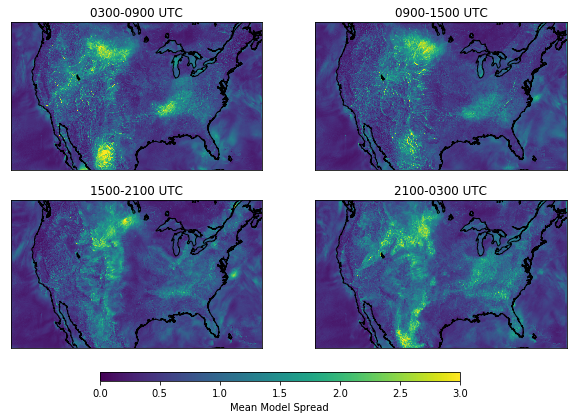

In [20]:
labels = ['0300-0900 UTC', '0900-1500 UTC', '1500-2100 UTC', '2100-0300 UTC']
fig, axes = plt.subplots(2,2, figsize=(10,6))
axes = axes.flatten()
for ax, v, label in zip(axes, [var_0309, var_0915, var_1521, var_2103], labels):
    plt.sca(ax)
    mesh = m.pcolormesh(LAND['lon'], LAND['lat'], np.sqrt(np.mean(v, axis=0)),
                        vmin=0, vmax=3,
                        latlon=True)
    m.drawcoastlines()
    plt.title(label)

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02]) # [left, bottom, width, height]
cb = fig.colorbar(mesh, cax=cbar_ax, ticks=np.arange(0,3.1,.5), orientation='horizontal')
cb.ax.set_xlabel(r'Mean Model Spread');

In [14]:
np.save('this',var_0309)

In [29]:
[np.mean(i) for i in [var_0309, var_0915, var_1521, var_2103]]

[0.7034977, 0.62462384, 0.6172604, 0.77908736]

In [26]:
VARS = ['UVGRD:10 m', 'REFC:entire', 'LTNG:entire', 'CAPE:surface', 'TMP:2 m', 'DPT:2 m', 'HGT:500']

seasons = {'DJF': {'sDATE':datetime(2017, 12, 1),
                   'eDATE':datetime(2018, 3, 1)},
           'MAM': {'sDATE':datetime(2018, 3, 1),
                   'eDATE':datetime(2018, 6, 1)},
           'JJA': {'sDATE':datetime(2018, 6, 1),
                   'eDATE':datetime(2018, 9, 1)},
           'SON': {'sDATE':datetime(2018, 9, 1),
                   'eDATE':datetime(2018, 12, 1)},}

In [27]:
for variable in VARS:
    for season in seasons.keys():
        sDATE = seasons[season]['sDATE']
        eDATE = seasons[season]['eDATE']
        # List of all days
        hours = (eDATE-sDATE).days*24
        DATES = [sDATE+timedelta(hours=h) for h in range(hours)]
        print(variable, season, sDATE, eDATE, len(DATES))

UVGRD:10 m DJF 2017-12-01 00:00:00 2018-03-01 00:00:00 2160
UVGRD:10 m MAM 2018-03-01 00:00:00 2018-06-01 00:00:00 2208
UVGRD:10 m JJA 2018-06-01 00:00:00 2018-09-01 00:00:00 2208
UVGRD:10 m SON 2018-09-01 00:00:00 2018-12-01 00:00:00 2184
REFC:entire DJF 2017-12-01 00:00:00 2018-03-01 00:00:00 2160
REFC:entire MAM 2018-03-01 00:00:00 2018-06-01 00:00:00 2208
REFC:entire JJA 2018-06-01 00:00:00 2018-09-01 00:00:00 2208
REFC:entire SON 2018-09-01 00:00:00 2018-12-01 00:00:00 2184
LTNG:entire DJF 2017-12-01 00:00:00 2018-03-01 00:00:00 2160
LTNG:entire MAM 2018-03-01 00:00:00 2018-06-01 00:00:00 2208
LTNG:entire JJA 2018-06-01 00:00:00 2018-09-01 00:00:00 2208
LTNG:entire SON 2018-09-01 00:00:00 2018-12-01 00:00:00 2184
CAPE:surface DJF 2017-12-01 00:00:00 2018-03-01 00:00:00 2160
CAPE:surface MAM 2018-03-01 00:00:00 2018-06-01 00:00:00 2208
CAPE:surface JJA 2018-06-01 00:00:00 2018-09-01 00:00:00 2208
CAPE:surface SON 2018-09-01 00:00:00 2018-12-01 00:00:00 2184
TMP:2 m DJF 2017-12-01 0

In [38]:
seasons[season]['mean domain spread LAND'] = [np.mean(np.ma.array(np.sqrt(np.mean(i, axis=0)), mask=LAND['value']==1)) for i in [var_0309, var_0915, var_1521, var_2103]]

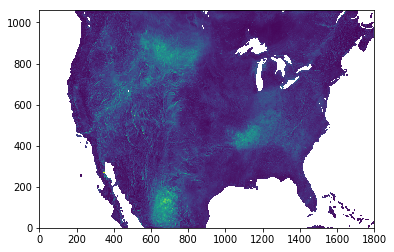

In [43]:
plt.pcolormesh(np.ma.array(np.sqrt(np.mean(var_0309, axis=0)), mask=LAND['value']==0))

In [39]:
seasons['SON']

{'sDATE': datetime.datetime(2018, 9, 1, 0, 0),
 'eDATE': datetime.datetime(2018, 12, 1, 0, 0),
 'mean domain spread': [0.719612, 0.6926259, 0.6960623, 0.77458465],
 'mean domain spread LAND': [0.5683374871974806,
  0.5852708611816246,
  0.5669891830252443,
  0.5711749054992947]}

In [40]:
all_variances = np.array(all_variances)

In [66]:
mean_spread = np.sqrt(np.mean(all_variances, axis=0))

In [74]:
mean_spread_land = np.ma.array(mean_spread, mask=LAND['value']==0)
mean_spread_water = np.ma.array(mean_spread, mask=LAND['value']==1)

In [77]:
avg_mean_spread = np.mean(mean_spread)
avg_mean_spread_land = np.mean(mean_spread_land)
avg_mean_spread_water = np.mean(mean_spread_water)

In [78]:
avg_mean_spread, avg_mean_spread_land, avg_mean_spread_water

(0.7937275, 0.8612909577098482, 0.6784437268009824)

In [53]:
mean_var = np.sqrt(np.mean(all_variances))
max_var = np.sqrt(np.max(all_variances))
min_var = np.sqrt(np.min(all_variances))

In [54]:
mean_var, max_var, min_var

(0.8905842, 9.831672, 0.025490234)

In [64]:
p = np.percentile(np.sqrt(all_variances), range(101))

MaskError: Mask and data not compatible: data size is 45723384, mask size is 1905141.

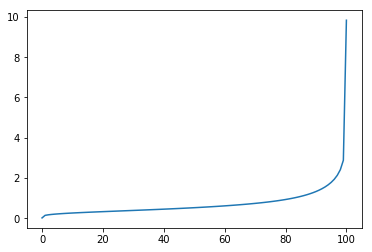

In [57]:
plt.plot(range(101), p)

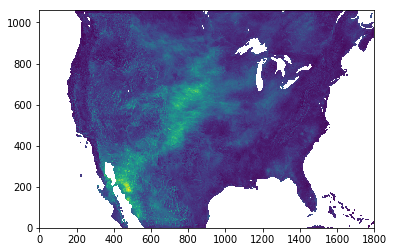

In [62]:
plt.pcolormesh(np.sqrt(np.ma.array(np.mean(all_variances, axis=0), mask=LAND['value']==0)))

In [46]:
seasons['DJF']['mean domain spread'] = np.array(seasons['SON']['mean domain spread'])*2
seasons['MAM']['mean domain spread'] = np.array(seasons['SON']['mean domain spread'])*3
seasons['JJA']['mean domain spread'] = np.array(seasons['SON']['mean domain spread'])*4

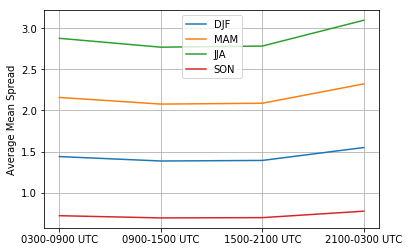

In [60]:
labels = ['0300-0900 UTC', '0900-1500 UTC', '1500-2100 UTC', '2100-0300 UTC']
for i in seasons.keys():
    plt.plot(seasons[i]['mean domain spread'], label=i)
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.grid()
plt.ylabel('Average Mean Spread')
plt.savefig('test', bbox_inches='tight')

making plot for HGT:500 SON


KeyError: 'mean domain spread LAND'

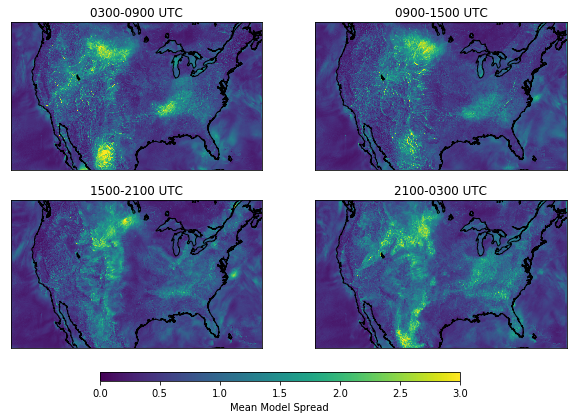

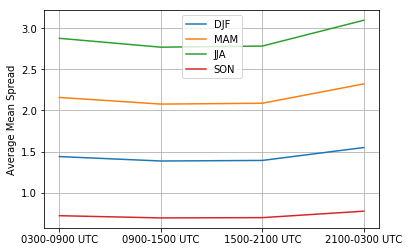

<Figure size 432x288 with 0 Axes>

In [58]:
print('making plot for', variable, season)
labels = ['0300-0900 UTC', '0900-1500 UTC', '1500-2100 UTC', '2100-0300 UTC']
fig, axes = plt.subplots(2,2, figsize=(10,6))
axes = axes.flatten()
for ax, v, label in zip(axes, [var_0309, var_0915, var_1521, var_2103], labels):
    plt.sca(ax)
    mesh = m.pcolormesh(LAND['lon'], LAND['lat'], np.sqrt(np.mean(v, axis=0)),
                        vmin=0, vmax=3,
                        latlon=True)
    m.drawcoastlines()
    plt.title(label)

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02]) # [left, bottom, width, height]
cb = fig.colorbar(mesh, cax=cbar_ax, ticks=np.arange(0,3.1,.5), orientation='horizontal')
cb.ax.set_xlabel(r'Mean Model Spread');

plt.savefig('./%s_%s' % (season, variable))


# Save mean spread statistics for area
seasons[season]['mean domain spread'] = [np.mean(np.sqrt(np.mean(i, axis=0))) for i in [var_0309, var_0915, var_1521, var_2103]]

seasons[season]['mean domain spread LAND'] = [np.mean(np.ma.array(np.sqrt(np.mean(i, axis=0)), mask=LAND['value']==0)) for i in [var_0309, var_0915, var_1521, var_2103]]

seasons[season]['mean domain spread WATER'] = [np.mean(np.ma.array(np.sqrt(np.mean(i, axis=0)), mask=LAND['value']==1)) for i in [var_0309, var_0915, var_1521, var_2103]]

plt.figure(2)
labels = ['0300-0900 UTC', '0900-1500 UTC', '1500-2100 UTC', '2100-0300 UTC']
for i in seasons.keys():
    plt.plot(seasons[i]['mean domain spread'], label=i)
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.grid()
plt.ylabel('Average Mean Spread')
plt.savefig('./domain_average_spread')

plt.figure(3)
labels = ['0300-0900 UTC', '0900-1500 UTC', '1500-2100 UTC', '2100-0300 UTC']
for i in seasons.keys():
    plt.plot(seasons[i]['mean domain spread LAND'], label=i)
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.grid()
plt.ylabel('Average Mean Spread')
plt.savefig('./domain_average_spread_LAND')

plt.figure(4)
labels = ['0300-0900 UTC', '0900-1500 UTC', '1500-2100 UTC', '2100-0300 UTC']
for i in seasons.keys():
    plt.plot(seasons[i]['mean domain spread WATER'], label=i)
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.grid()
plt.ylabel('Average Mean Spread')
plt.savefig('./domain_average_spread_WATER')

In [59]:
seasons

{'DJF': {'sDATE': datetime.datetime(2017, 12, 1, 0, 0),
  'eDATE': datetime.datetime(2018, 3, 1, 0, 0),
  'mean domain spread': array([1.439224 , 1.3852518, 1.3921247, 1.5491693], dtype=float32)},
 'MAM': {'sDATE': datetime.datetime(2018, 3, 1, 0, 0),
  'eDATE': datetime.datetime(2018, 6, 1, 0, 0),
  'mean domain spread': array([2.158836 , 2.0778775, 2.088187 , 2.3237538], dtype=float32)},
 'JJA': {'sDATE': datetime.datetime(2018, 6, 1, 0, 0),
  'eDATE': datetime.datetime(2018, 9, 1, 0, 0),
  'mean domain spread': array([2.878448 , 2.7705035, 2.7842493, 3.0983386], dtype=float32)},
 'SON': {'sDATE': datetime.datetime(2018, 9, 1, 0, 0),
  'eDATE': datetime.datetime(2018, 12, 1, 0, 0),
  'mean domain spread': [0.719612, 0.6926259, 0.6960623, 0.77458465],
  'mean domain spread LAND': [0.8082684248296256,
   0.7555420075126251,
   0.7717078567872538,
   0.8937946748941455],
  'mean domain spread WATER': [0.5683374871974806,
   0.5852708611816246,
   0.5669891830252443,
   0.571174905499294